# Zigzag

## functions

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

global ny, N, a1
ny = 10 # unit cell number in y direction
N = 2*ny
a1 = np.sqrt(3)/(2) # a = 1, a1 = a*sqrt(3)/2
    
def NB(T, E):
    # Bose distribution
    E = np.real(E)
    if abs(E/T) > 500:
        return 0
    else: return 1/(np.exp(E/T) - 1) 

def eigenv(H):
    '''  setup eigenvalues and eigenvectors
    parameters:
        H: np.ndarray
            Hamiltonian matrix
    returns:
        E: list
            eigenvalues
        U: np.ndarray
            eigenvectors
            U[i, m]: m: energy, i: sites
        U_dag: np.ndarray
            conjugate transpose of U
    '''
    
    E, U = np.linalg.eig(H)
    # E -= np.min(E)+1e-10 # shift to positive
    # print(f'Eigenvalue: {E}')
    U_dag = np.conjugate(U).T
    
    return E, U, U_dag
    # return E

def hamiltonian_0(j, J, d, h, k):
    ''' H in A, B basis
    '''
    
    ni = lambda i: i % N
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    phase = np.exp(1j * k * a1)
    Pnn = j*(phase + 1/phase)
    Pnnn = J*(phase + 1/phase)
    Pd = 1j*d*(phase - 1/phase)
    
    mat = np.eye(N, dtype=np.complex64) * (3*j+6*J+h + J*(phase**2+1/(phase**2)))
    
    for i in A:
        
        mat[ni(i), ni(i+1)] += Pnn
        mat[ni(i), ni(i-1)] += j 
        
        mat[ni(i), ni(i+2)] += (Pnnn + Pd)
        mat[ni(i), ni(i-2)] += (Pnnn + Pd)
        mat[ni(i+2), ni(i)] += (Pnnn + Pd)
        mat[ni(i-2), ni(i)] += (Pnnn + Pd)
        mat[ni(i), ni(i)] -= 1j*d*(phase**2 - 1/(phase**2))
        
    for i in B: 
        
        mat[ni(i), ni(i+1)] += j
        mat[ni(i), ni(i-1)] += Pnn
        
        mat[ni(i), ni(i+2)] += (Pnnn - Pd)
        mat[ni(i), ni(i-2)] += (Pnnn - Pd)
        mat[ni(i+2), ni(i)] += (Pnnn - Pd)
        mat[ni(i-2), ni(i)] += (Pnnn - Pd)
        mat[ni(i), ni(i)] += 1j*d*(phase**2 - 1/(phase**2))
        
    # boundary condition
    
    i = 0
    mat[ni(i), ni(i-1)] = 0
    mat[ni(i), ni(i-2)] = 0
    
    i = 1
    mat[ni(i), ni(i-2)] = 0
    
    i = N-2
    mat[ni(i), ni(i+2)] = 0
    
    i = N-1
    mat[ni(i), ni(i+1)] = 0
    mat[ni(i), ni(i+2)] = 0

    return mat/2

def hamiltonian_mft(iteration, T, jn, J, d, h, kx, txtout=None):
    ''' H in u, d basis
    '''
    
    K = kx*a1
    
    H_0 = hamiltonian_0(jn, J, d, h, kx)
    E, U, U_dag = eigenv(H_0) # 1st order eigenvalues and eigenvectors
    
    Ei = np.sort(E)
    if txtout is not None:
        with open(txtout, 'w') as f:
            for i in range(N):
                f.write(f'E{i},')
            f.write('\n')
            for i in range(N):
                f.write(f'{np.real(Ei[i])},')
            f.write('\n')
    
    H = np.zeros((N, N), dtype=np.complex64)
    H += U_dag @ H_0 @ U # 1st order H in u, d basis
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    for iter in range(iteration):
        
        def V(m, n, i, j):
            if i < 0 or i >= N or j < 0 or j >= N:
                return 0 # OBC
            else: return U_dag[m, i] * U[j, n]
        
        N_b = 0
        for i in range(N):
            N_b += NB(T, E[i]) / N
        print(f'Number of bosons per site: {N_b}')
        
        for m in range(N):
            for n in range(N):
                
                for a in A:
                    # NN terms
                    H[m, n] += (jn*N_b) * (V(m,n,a,a-1) + V(m,n,a-1,a) - V(m,n,a-1,a-1) - V(m,n,a,a))
                    H[m, n] += (jn*N_b) * (V(m,n,a,a+1) + V(m,n,a+1,a) - V(m,n,a+1,a+1) - V(m,n,a,a)) * 2*np.cos(K)
                    
                    # NNN terms
                    H[m, n] += (J*N_b) * (V(m,n,a,a-2)+V(m,n,a-2,a)-V(m,n,a-2,a-2)-V(m,n,a,a)) * 2*np.cos(K)
                    H[m, n] += (J*N_b) * (V(m,n,a,a+2)+V(m,n,a+2,a)-V(m,n,a+2,a+2)-V(m,n,a,a)) * 2*np.cos(K)
                    
                    # DMI terms
                    H[m, n] += (d*N_b) * (V(m,n,a,a-2)-V(m,n,a-2,a)+V(m,n,a,a+2)-V(m,n,a+2,a)) * 2*np.sin(K)
                    
                for b in B:
                    # NN terms
                    H[m, n] += (jn*N_b) * (V(m,n,a,a-1) + V(m,n,a-1,a) - V(m,n,a-1,a-1) - V(m,n,a,a)) * 2*np.cos(K)
                    H[m, n] += (jn*N_b) * (V(m,n,a,a+1) + V(m,n,a+1,a) - V(m,n,a+1,a+1) - V(m,n,a,a))
                    
                    # NNN terms
                    H[m, n] += (J*N_b) * (V(m,n,a,a-2)+V(m,n,a-2,a)-V(m,n,a-2,a-2)-V(m,n,a,a)) * 2*np.cos(K)
                    H[m, n] += (J*N_b) * (V(m,n,a,a+2)+V(m,n,a+2,a)-V(m,n,a+2,a+2)-V(m,n,a,a)) * 2*np.cos(K)
                    
                    # DMI terms
                    H[m, n] -= (d*N_b) * (V(m,n,a,a-2)-V(m,n,a-2,a)+V(m,n,a,a+2)-V(m,n,a+2,a)) * 2*np.sin(K)
                    
        E, U, U_dag = eigenv(H)
        print(f'det(UUdagger)={np.linalg.det(U@U_dag)}')
        # E, _, __ = eigenv(H)
        
        # Ei = np.append(Ei, np.sort(E), axis=0)
        Ei = np.sort(E)
        if txtout is not None:
            with open(txtout, 'a') as f:
                for i in range(N):
                    f.write(f'{np.real(Ei[i])},')
                f.write('\n')
    
        print(f'Iteration {iter} finished.')
        
        # with open(f'./H{T}{jn}{J}{d}.txt', 'a') as f:
        #     f.write(f'Iteration {iter} H matrix:\n')
        #     for i in range(N):
        #         for j in range(N):
        #             f.write('{0:.4f},'.format(np.real(H[i, j])))
        #         f.write('\n')
    
    return E

## 1st order

In [23]:
j = 1
J = 0.
D = 0.1
h = 0.0
T = 0.1

K = np.pi/a1
spec = np.linspace(0, K, 201)
Erp = []
# bc = ['A', 'B'] # boundary condition
for k in spec:
    E = 0
    H = hamiltonian_0(j, J, D, h, k)
    E, _, _ = eigenv(H)
    Erp.append(np.real(E))
Er = np.array(Erp)
bands = np.array([spec] * len(E))/K

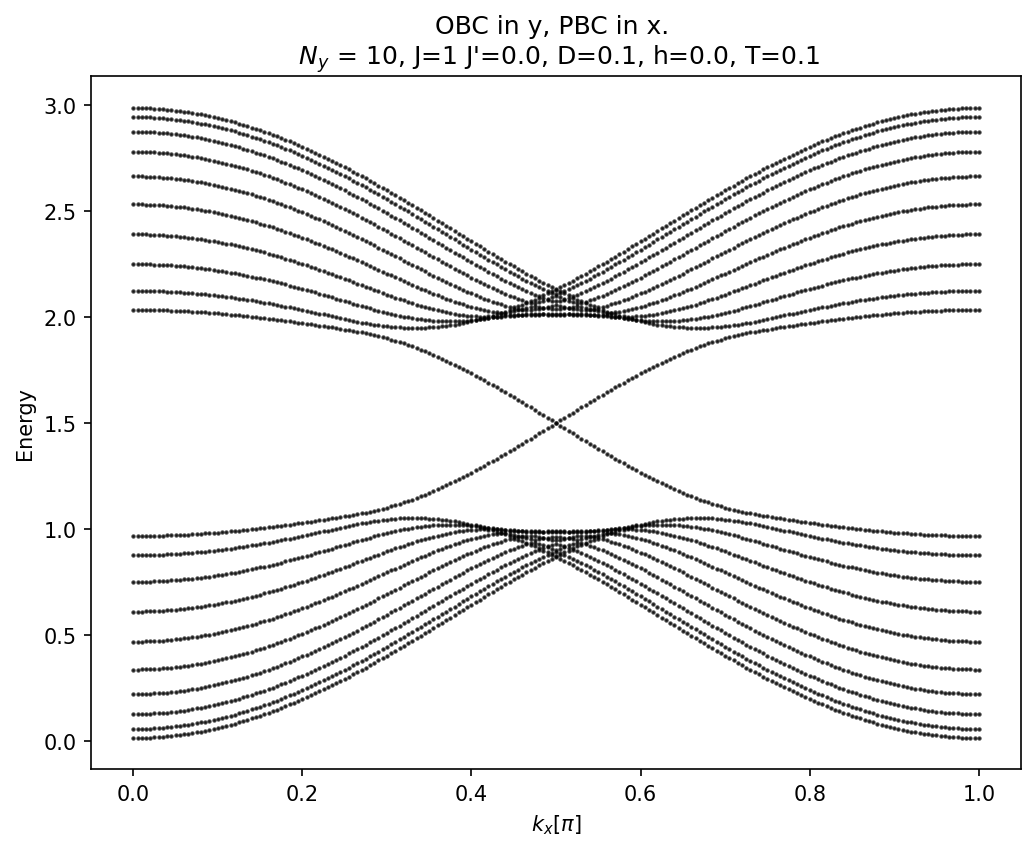

In [24]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

for i in range(len(E)):
    # j = i/N
    c = ['r', 'g', 'b', 'c']
    marks = ['o', 'D', 's']
    # colormap viridis
    # ax.scatter(bands[i, :], Er[:,i], color=plt.cm.hsv(j), s=10, alpha=0.8, marker=f'{marks[i%3]}')
    ax.scatter(bands[i, :], Er[:,i], 
        # color=f'{c[i%4]}', s=5, alpha=0.7, marker=f'{marks[i%3]}')
        color='k', s=5, alpha=0.7, marker='.')
    
ax.set_xlabel('$k_x [\\pi]$')
ax.set_ylabel('Energy')
# ax.set_xlim(0, 1)
# ax.set_xlim(0.5, 1.5)
# ax.set_ylim(-0.7, 0.7)
title = f"OBC in y, PBC in x. \n $N_y$ = {ny}, J={j} J'={J}, D={D}, h={h}, T={T}"
ax.set_title(title)

# plt.savefig(f'./louvre/cylinder_m{m}_J{j}_Jp{J}_D{D}_h{h}_T{T}_{bc[0]}{bc[1]}.png', dpi=100)

plt.show()

## 2nd order

### spectrum

In [ ]:
j = 1
J = 0.
D = 0.
h = 0.0
T = 0.2

iter = 20

K = np.pi/a1
spec = np.array([0, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 1.0])*K
# spec = np.linspace(0, K, 11)
# spec = np.linspace(0.4*K, 0.6*K, 11)
E_1 = []
E_2 = []
# bc = ['A', 'B'] # boundary condition
for k in spec:
    Ea = 0
    Eb = 0
    Ea, _, _ = eigenv(hamiltonian_0(j, J, D, h, k))
    E_1.append(np.real(Ea))
    Eb = hamiltonian_mft(iter, T, j, J, D, h, k)
    E_2.append(np.real(Eb))
    
E1 = np.array(E_1)
E2 = np.array(E_2)
bands = np.array([spec] * len(Ea))/K

Iteration 0 finished.
Iteration 1 finished.
Iteration 2 finished.
Iteration 3 finished.
Iteration 4 finished.
Iteration 5 finished.
Iteration 6 finished.
Iteration 7 finished.
Iteration 8 finished.
Iteration 9 finished.
Iteration 10 finished.
Iteration 11 finished.
Iteration 12 finished.
Iteration 13 finished.
Iteration 14 finished.
Iteration 15 finished.
Iteration 16 finished.
Iteration 17 finished.
Iteration 18 finished.
Iteration 19 finished.
Iteration 0 finished.
Iteration 1 finished.
Iteration 2 finished.
Iteration 3 finished.
Iteration 4 finished.
Iteration 5 finished.
Iteration 6 finished.
Iteration 7 finished.
Iteration 8 finished.
Iteration 9 finished.
Iteration 10 finished.
Iteration 11 finished.
Iteration 12 finished.
Iteration 13 finished.
Iteration 14 finished.
Iteration 15 finished.
Iteration 16 finished.
Iteration 17 finished.
Iteration 18 finished.
Iteration 19 finished.
Iteration 0 finished.
Iteration 1 finished.
Iteration 2 finished.
Iteration 3 finished.
Iteration 4 

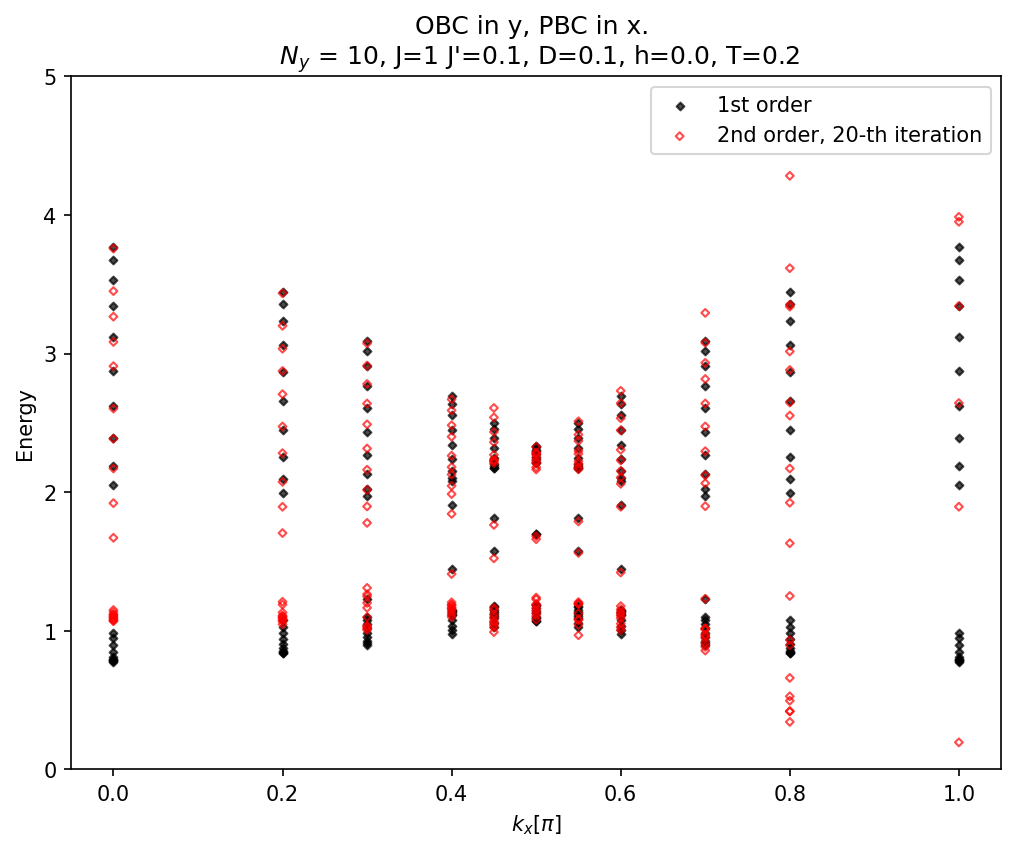

In [82]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

for i in range(len(Ea)-1):
    ax.scatter(bands[i, :], E1[:,i], 
        color='k', s=7, alpha=0.7, marker='D')
    ax.scatter(bands[i, :], E2[:,i], 
        edgecolors='r', facecolors='none', s=7, alpha=0.7, marker='D', zorder=10)

ax.scatter(bands[N-1, :], E1[:,N-1], 
    color='k', s=7, alpha=0.7, marker='D', label='1st order', zorder=1)
ax.scatter(bands[N-1, :], E2[:,N-1], 
    edgecolors='r', facecolors='none', s=7, alpha=0.7, marker='D', label=f'2nd order, {iter}-th iteration', zorder=10)
    
ax.set_xlabel('$k_x [\\pi]$')
ax.set_ylabel('Energy')
# ax.set_xlim(0, 1)
# ax.set_xlim(0.5, 1.5)
ax.set_ylim(0, 5)
ax.legend()
title = f"OBC in y, PBC in x. \n $N_y$ = {ny}, J={j} J'={J}, D={D}, h={h}, T={T}"
ax.set_title(title)

plt.savefig(f'./louvre/MagnonMFT_{ny}_J{j}_Jp{J}_D{D}_h{h}_T{T}_itr{iter}.png', dpi=100)

plt.show()

### convergence

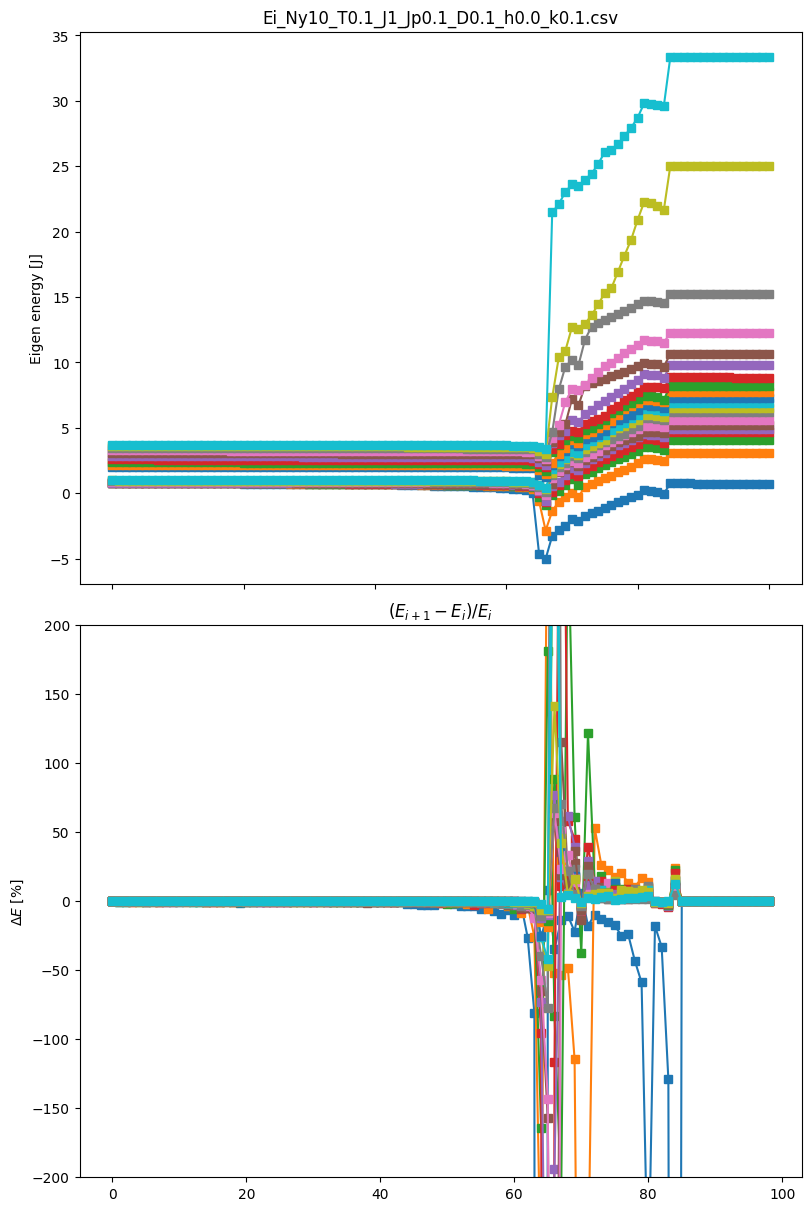

In [72]:
file = f'Ei_Ny{10}_T{0.1}_J{1}_Jp{0.1}_D{0.1}_h{0.0}_k{0.1}.csv'
iterations = 100

fig, axs = plt.subplots(2, 1, figsize=(8, 12), layout='constrained')

data = pd.read_csv('./data/' + file)

ax = axs[0]
for i in range(len(data.columns)):
    ax.plot(data.iloc[:, i], label=f'E{i}', marker='s')
    
# ax.set_ylim(0, 5)
ax.set_ylabel('Eigen energy [J]')
ax.label_outer()
ax.set_title(file)

ax = axs[1]
for i in range(len(data.columns)):
    delta = []
    for j in range(iterations-1):
        delta.append(100*(data.iloc[j+1, i]-data.iloc[j, i])/data.iloc[j, i])
    ax.plot(delta, label=f'E{i}', marker='s')

ax.set_ylim(-200, 200)
ax.set_ylabel('$\Delta E$ [%]')
ax.set_title('$(E_{i+1} - E_i)/E_i$')

# plt.savefig(f'./louvre/{file[:-4]}.png', dpi=100)
plt.show()

In [71]:
j = 1
J = 0.1
D = 0.1
h = 0.0
T = 0.1

iter = 100

k = 0.1
K = k*np.pi/a1

file = f'./data/Ei_Ny{ny}_T{T}_J{j}_Jp{J}_D{D}_h{h}_k{k}.csv'

hamiltonian_mft(iter, T, j, J, D, h, K, txtout=file)
# hamiltonian_mft(3, T, j, J, D, h, K)

Number of bosons per site: 0.00011185417044011461
det(UUdagger)=(0.9999619722366333-1.6717465361657686e-24j)
Iteration 0 finished.
Number of bosons per site: 0.00011308609100524336
det(UUdagger)=(0.9984017610549927+8.240917487925443e-24j)
Iteration 1 finished.
Number of bosons per site: 0.00011470892059151083
det(UUdagger)=(0.9964287877082825+5.302446114717909e-24j)
Iteration 2 finished.
Number of bosons per site: 0.00011639638978522271
det(UUdagger)=(0.9917438626289368+1.5517665117232156e-24j)
Iteration 3 finished.
Number of bosons per site: 0.00011807888222392648
det(UUdagger)=(0.5645505785942078+2.176294571629837e-22j)
Iteration 4 finished.
Number of bosons per site: 0.00011985181481577456
det(UUdagger)=(0.4610852599143982+2.589812428920815e-21j)
Iteration 5 finished.
Number of bosons per site: 0.00012184225488454103
det(UUdagger)=(0.9763495922088623-6.0082908008158805e-22j)
Iteration 6 finished.
Number of bosons per site: 0.0001239192351931706
det(UUdagger)=(0.9922755360603333+7.84

/tmp/ipykernel_1008/2770607706.py:15: RuntimeWarning: overflow encountered in exp
  else: return 1/(np.exp(E/T) - 1)


det(UUdagger)=(0.9156898856163025-7.108287292112436e-09j)
Iteration 67 finished.
Number of bosons per site: -0.08949846774339676
det(UUdagger)=(0.9552916288375854-7.047772365709193e-10j)
Iteration 68 finished.
Number of bosons per site: -0.10184618085622787
det(UUdagger)=(0.9464776515960693+3.917041357937023e-09j)
Iteration 69 finished.
Number of bosons per site: 0.0310638677328825
det(UUdagger)=(0.9458205103874207+4.2150070100888115e-09j)
Iteration 70 finished.
Number of bosons per site: -0.10380073636770248
det(UUdagger)=(0.9067356586456299+3.2466547228438003e-09j)
Iteration 71 finished.
Number of bosons per site: -0.04956681653857231
det(UUdagger)=(0.9255189895629883+5.68036895298718e-10j)
Iteration 72 finished.
Number of bosons per site: -0.0499657541513443
det(UUdagger)=(0.9271360039710999-2.0113160026369314e-09j)
Iteration 73 finished.
Number of bosons per site: -0.04999493435025215
det(UUdagger)=(0.9497733116149902+1.1053278292649793e-08j)
Iteration 74 finished.
Number of bosons

array([33.353428  -0.01047759j, 25.043602  -0.00135865j,
       15.20859   -0.01635507j,  0.73814654-0.00050461j,
       12.279491  +0.01096434j, 10.641786  +0.04395787j,
        3.0576458 +0.00553637j,  9.827012  +0.01670172j,
        8.843757  +0.00169405j,  4.0934405 -0.01366246j,
        8.227457  +0.00612043j,  4.6498976 -0.00325729j,
        4.9369783 -0.01618794j,  5.2234974 -0.015971j  ,
        5.6219196 +0.00019733j,  7.7216706 +0.00490948j,
        7.241232  -0.01189307j,  6.216217  +0.0001108j ,
        6.543726  +0.0137234j ,  6.9202824 -0.00674902j], dtype=complex64)